## 必要なモジュールのインポートとベジェ曲線用のクラスの定義

In [1]:
import numpy as np
import bezier #ベジェ曲線をプロットするためのモジュール
import matplotlib.pyplot as plt
import seaborn

class BezierLength:
    def __init__(self,node):
        p = [] #始点，制御点１，制御点２，終点を入れるリスト
        for i in range(4):
            p.append(np.array([node[0][i],node[1][i]]))

        self.p = p
        
        ###########################################################
        #
        # P(t)=(1-t)^3*P0 + 3t(1-t)^2*P1 + 3t^2(1-t)*P2 + t^3*P3
        #      =At^3 + Bt^2 + Ct + D
        # とすると
        # A=-P0 + 3P1 - 3P2 + P3
        # B=3P0 - 6P1 + 3P2
        # C=-3P0 + 3P1
        # D=P0
        # 微分すると，
        # P'(t)=3At^2 + 2Bt + C
        # これを二乗する
        # (P'(t))^2 = 9A^2t^4 + 12ABt^3 + (6AC+4B^2)t^2 + 4BCt + C^2
        #
        ###########################################################
        
        A = -p[0] + 3*p[1] - 3*p[2] + p[3] 
        B = 3*p[0] - 6*p[1] + 3*p[2]
        C = -3*p[0] + 3*p[1]
        D = p[0]
        self.A = A
        self.B = B
        self.C = C
        self.D = D

        coef = []
        coef.append(9*np.sum(A**2))
        coef.append(12*np.sum(A*B))
        coef.append(6*np.sum(A*C) + 4*np.sum(B**2))
        coef.append(4*np.sum(B*C))
        coef.append(np.sum(C**2))
        self.coef = coef
        
    def get_points_on_beziercurve(self, num=100):
        results = np.empty((2,0))
        interval = np.linspace(0,1,num)
        for t in interval:
            results = np.concatenate([results,np.reshape(self.A*t**3 + self.B*t**2 + self.C*t + self.D, (2,1))],axis=1)
        
        return results
        
    def divf(self,s):
        return np.sqrt(self.coef[0]*s**4 + self.coef[1]*s**3 + self.coef[2]*s**2 + self.coef[3]*s + self.coef[4])
    
    def get_length_by_Euler(self, div=100):
        length = 0
        interval = np.linspace(0,1,div)
        for t in interval[:-1]:
            f = self.divf(t)
            length = length + f / div
            
        return length  
    
    def get_length_by_RungeKutta(self, div=100):
        length = 0
        interval = np.linspace(0,1,div)
        h = 1.0/div
        for t in interval[1:]:
            k1 = self.divf(t)
            k2 = self.divf(t + (h/2))
            k3 = self.divf(t + (h/2))
            k4 = self.divf(t + h)
            y = h * (k1 + 2*k2 + 2*k3 + k4) / 6.0
            length = length + y
            
        return length
    
    def get_length_by_3rdRungeKutta(self, div=100):
        length = 0
        interval = np.linspace(0,1,div)
        h = 1.0/div
        for t in interval[1:]:
            k1 = self.divf(t)
            k2 = self.divf(t + (h/2))
            k3 = self.divf(t + h)
            y = h * (k1 + 4*k2 + k3) / 6.0
            length = length + y

        return length
    
    def get_length_by_Pythagoras(self, div=100):
        points = self.get_points_on_beziercurve(div)
        length = 0
        for i in range(len(points[0])-1):
            x_0 = points[0][i]
            x_1 = points[0][i+1]
            y_0 = points[1][i]
            y_1 = points[1][i+1]
            length = length + np.sqrt((x_0-x_1)**2 + (y_0-y_1)**2)
            
        return length
    
    def get_length_by_Simpson(self, div=100):
        if div % 2 == 1:
            div = div+1
            
        interval= np.linspace(0,1,div)
        length = 0
        for index, t in enumerate(interval):
            if index == 0 or index == interval[-1]:
                length = length + self.divf(t)
            elif index % 2 == 0:
                length = length + 2*self.divf(t)
            elif index % 2 == 1:
                length = length + 4*self.divf(t)
                    
        length = length / 3 / div
        return length

## 始点，制御点１，制御点２，終点を与えてベジェ曲線を描く

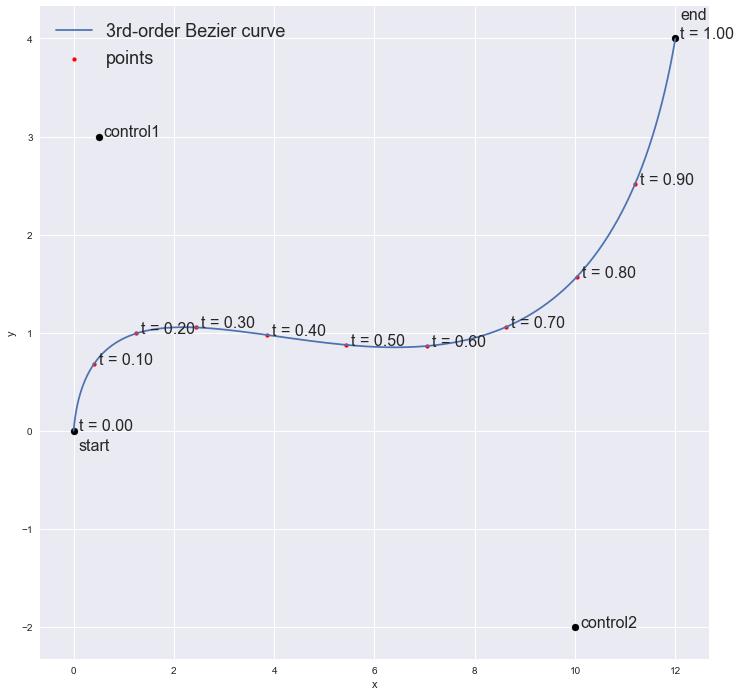

In [4]:
seaborn.set(rc={'figure.figsize':(12,12),'font.size':16})

# 始点：(x0,y0)
x0, y0 = 0.0, 0.0

# 制御点１：(x1,y1)
x1, y1 = 0.5, 3.0

# 制御点２：(x2,y2)
x2, y2 = 10.0, -2.0

# 終点：(x3,y3)
x3, y3 = 12.0, 4.0

nodes = np.asfortranarray([[x0,x1,x2,x3],[y0,y1,y2,y3]])

bezierLength = BezierLength(nodes)
curve = bezier.Curve(nodes, degree=2)

# ベジェ曲線をプロット
ax = curve.plot(num_pts=256)

# tを動かしたときのベジェ曲線上の位置
plt.scatter(res[0],res[1],c='red',s=15)
ax.legend(["3rd-order Bezier curve","points"],fontsize=18)

# 始点，制御点１，制御点２，終点をプロット
plt.scatter([x0,x1,x2,x3],[y0,y1,y2,y3], c="black")
ax.annotate("start",(x0+0.1,y0-0.2))
ax.annotate("control1",(x1+0.1,y1))
ax.annotate("control2",(x2+0.1,y2))
ax.annotate("end",(x3+0.1,y3+0.2))

div = 11
t = np.linspace(0,1,div)
res = bezierLength.get_points_on_beziercurve(div)


for i in range(div):
    ax.annotate("t = %.2f" % t[i], (res[0][i]+0.1,res[1][i]))
    
plt.xlabel("x")
plt.ylabel("y")

plt.show()

## いろんな手法でベジェ曲線の長さを求める

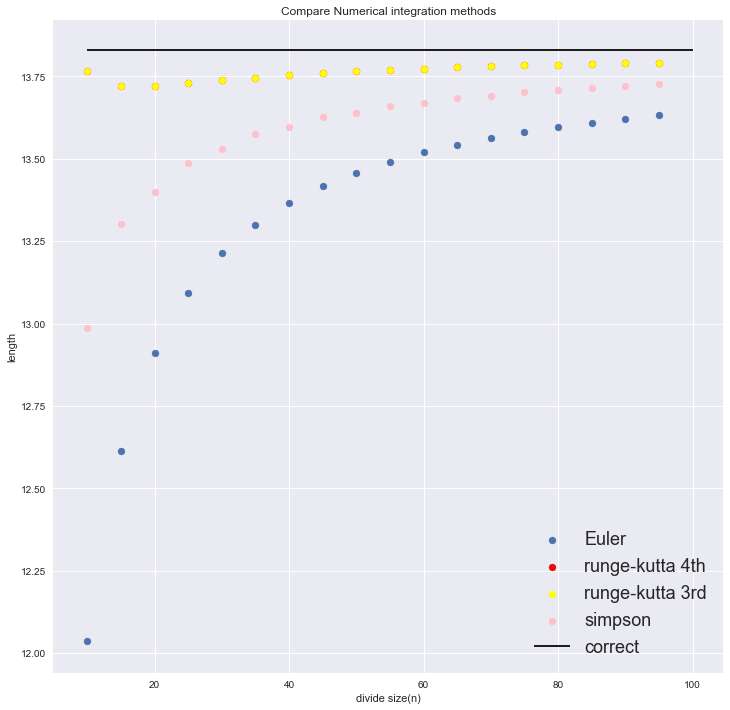

In [5]:
_xmin = 10
_xmax = 100
_x = np.arange(_xmin,_xmax,5)

# オイラー法での長さ
euler = []
# 4次ルンゲクッタ法での長さ
runge4th = []
# ３次ルンゲクッタ法での長さ
runge3rd = []
# シンプソン法での長さ
simpson = []
# ベジェ曲線を1000本の極短の直線で近似して求めた長さ
correct = bezierLength.get_length_by_Pythagoras(1000)

for value in _x:
    euler.append(bezierLength.get_length_by_Euler(value))
    runge4th.append(bezierLength.get_length_by_RungeKutta(value))
    runge3rd.append(bezierLength.get_length_by_3rdRungeKutta(value))
    simpson.append(bezierLength.get_length_by_Simpson(value))
    
plt.scatter(_x, euler, label="Euler")
plt.scatter(_x, runge4th, label="runge-kutta 4th",c='red')
plt.scatter(_x, runge3rd, label="runge-kutta 3rd",c="yellow")
plt.scatter(_x, simpson, label="simpson",c="pink")

plt.title("Compare Numerical integration methods")
plt.xlabel("divide size(n)")
plt.ylabel("length")
plt.hlines(y=correct,xmin=_xmin,xmax=_xmax,label="correct")
plt.legend(loc='lower right', fontsize = 18)  # 凡例をグラフにプロット

plt.show()

### おまけ；$Q(s) = \int_0^s \{P'(t)\}^2 dt$として$s=0$から$s=1$に動かして関数の概形をみてみる

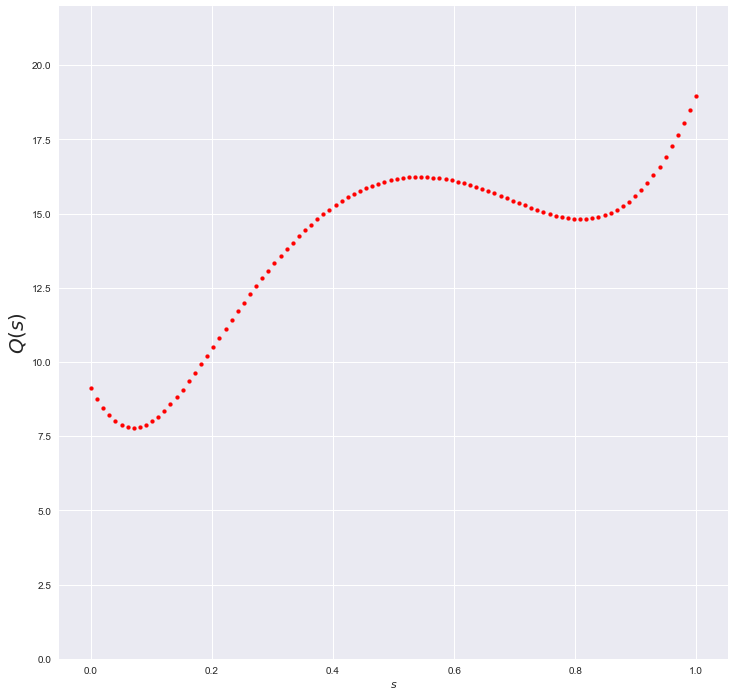

In [10]:
_x = np.linspace(0,1,100)
lengthFunc = bezierLength.divf(_x)
plt.scatter(_x,lengthFunc,c='red',s=15)
plt.xlabel(r"$s$")
plt.ylabel(r"$Q(s)$",fontSize=20)
plt.ylim([0,max(lengthFunc++3)])
plt.show()